In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from scipy.stats import qmc 
import matplotlib.pyplot as plt
from matplotlib import cm 

device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
print(device)

cuda:0


주요 수정사항:

1. numpy 내장 uniform distribution sampling 대신에 논문과 동일하게 Latin HyperCube Sampling 사용
2. 논문과 동일한 모델 구조 설계
3. 코드 가독성 개선
4. 결과 이미지 논문과 동일하게 설정


In [11]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25
# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1) #engine for samepling random points

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5) #기본적으로 qmc는 0,1 사이의 난수를 생성 하므로 -1,1 범위로 난수 스케일링
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

#나중에 t_d, x_d를 합칠거니 이렇게 생성했고, 앞 50개는 초기조건, 뒤 50개는 경계조건 데이터

In [12]:
#output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0
     

# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)
     

Text(0.5, 1.0, 'Data points (BCs & IC)')

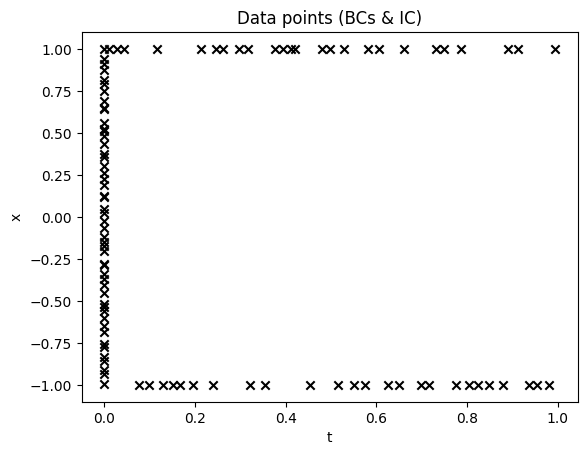

In [13]:
plt.scatter(t_d, x_d, marker="x", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [14]:
class Net(nn.Module) :
    def __init__(self, layerlist, actftn=torch.tanh, initializer=nn.init.xavier_uniform_) :
        super(Net,self).__init__()
        self.actftn = actftn
        self.layers = nn.ModuleList()

        for i in range(len(layerlist)-1):
            self.layers.append(nn.Linear(layerlist[i],layerlist[i+1]))



    def forward(self,x,t) :
        inputs = torch.cat([x,t],axis =1 )
        out = inputs
        for layer in self.layers[:-1]:
            out = self.actftn(layer(out))

        output =self.layers[-1](out) 
        return output
    
    


In [15]:
net = Net([2,20,20,20,20,20,20,20,1]) # is what we defined and stands for net.
net = net.to(device) #is to send net calculation to device
mse_cos_function = torch.nn.MSELoss() #is mean squared error loss function
optimizer = torch.optim.Adam(net.parameters()) # is for optimizer name Adam for parameters in our model.


In [16]:
def f(x,t,net) :
    u = net(x,t) # is to let u is given by the network based on independent variables x,t. so we need u_t and u_x
    #define u_t and u_x
    
    u_x = torch.autograd.grad(u.sum(),x,create_graph=True)[0] 
    u_t = torch.autograd.grad(u.sum(),t,create_graph=True)[0] 
    u_xx = torch.autograd.grad(u_x.sum(),x,create_graph=True)[0]
    pde = u_t + u*u_x - (0.01/np.pi)*u_xx
    return pde

In [17]:
iterations = 20000
previous_validation_loss=99999999.0
losses=[]
pt_x_d = Variable(torch.from_numpy(x_d).float(),requires_grad=False).to(device)
pt_t_d = Variable(torch.from_numpy(t_d).float(),requires_grad=False).to(device) 
pt_y_d = Variable(torch.from_numpy(y_d).float(),requires_grad=False).to(device)
all_zeros = np.zeros((Nc,1))
    
pt_x_c = Variable(torch.from_numpy(x_c).float(),requires_grad=True).to(device)
pt_t_c = Variable(torch.from_numpy(t_c).float(), requires_grad=True).to(device)
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
for epoch in range(iterations) :
    optimizer.zero_grad()
    
    #loss based on bc

    
    net_bc_out = net(pt_x_d,pt_t_d)
    mse_u = mse_cos_function(net_bc_out,pt_y_d)
    
    
    
    #loss based on PDE
    
 
    all_zeros = np.zeros((Nc,1))
    
    pt_x_c = Variable(torch.from_numpy(x_c).float(),requires_grad=True).to(device)
    pt_t_c = Variable(torch.from_numpy(t_c).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_c,pt_t_c,net)
    mse_f = mse_cos_function(f_out,pt_all_zeros)
    
    loss = mse_u+ mse_f
    
    loss.backward()
    
    optimizer.step()
    
    with torch.autograd.no_grad():
        print(epoch,"training loss",loss.data)
        print(mse_u)
        loss_value = loss.item()
        losses.append(loss_value)

0 training loss tensor(0.3039, device='cuda:0')
tensor(0.3038, device='cuda:0', grad_fn=<MseLossBackward0>)
1 training loss tensor(0.2948, device='cuda:0')
tensor(0.2947, device='cuda:0', grad_fn=<MseLossBackward0>)
2 training loss tensor(0.2866, device='cuda:0')
tensor(0.2866, device='cuda:0', grad_fn=<MseLossBackward0>)
3 training loss tensor(0.2794, device='cuda:0')
tensor(0.2794, device='cuda:0', grad_fn=<MseLossBackward0>)
4 training loss tensor(0.2731, device='cuda:0')
tensor(0.2731, device='cuda:0', grad_fn=<MseLossBackward0>)
5 training loss tensor(0.2677, device='cuda:0')
tensor(0.2676, device='cuda:0', grad_fn=<MseLossBackward0>)
6 training loss tensor(0.2630, device='cuda:0')
tensor(0.2630, device='cuda:0', grad_fn=<MseLossBackward0>)
7 training loss tensor(0.2591, device='cuda:0')
tensor(0.2591, device='cuda:0', grad_fn=<MseLossBackward0>)
8 training loss tensor(0.2559, device='cuda:0')
tensor(0.2559, device='cuda:0', grad_fn=<MseLossBackward0>)
9 training loss tensor(0.253

0 training loss: 0.001206515240482986
1 training loss: 0.0006976056611165404
2 training loss: 0.00039052381180226803
3 training loss: 0.0003908486687578261
4 training loss: 0.0005748135154135525
5 training loss: 0.0007893090369179845
6 training loss: 0.000790454912930727
7 training loss: 0.0005566022591665387
8 training loss: 0.0002841130772139877
9 training loss: 0.0002480513066984713
10 training loss: 0.0003680991067085415
11 training loss: 0.0005073780193924904
12 training loss: 0.0005455329082906246
13 training loss: 0.00039698061300441623
14 training loss: 0.0002441575052216649
15 training loss: 0.0002023577253567055
16 training loss: 0.0002778882044367492
17 training loss: 0.0003712975885719061
18 training loss: 0.00037800942664034665
19 training loss: 0.000320710358209908
20 training loss: 0.00023742596386000514
21 training loss: 0.0002056268131127581
22 training loss: 0.00023460129159502685
23 training loss: 0.00026775035075843334
24 training loss: 0.00027738517383113503
25 tra

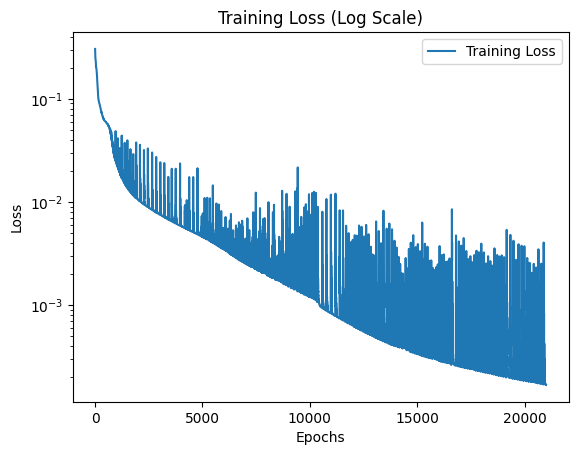

In [18]:
iterations = 1000
previous_validation_loss = 99999999.0


for epoch in range(iterations):
    # L-BFGS에 필요한 closure 함수 정의
    def closure():
        # 1) 기존 그래디언트 초기화
        optimizer.zero_grad()

        # 2) BC (Boundary/Initial Condition) 손실 계산
        pt_x_d = Variable(torch.from_numpy(x_d).float(), requires_grad=False).to(device)
        pt_t_d = Variable(torch.from_numpy(t_d).float(), requires_grad=False).to(device)
        pt_y_d = Variable(torch.from_numpy(y_d).float(), requires_grad=False).to(device)

        net_bc_out = net(pt_x_d, pt_t_d)
        mse_u = mse_cos_function(net_bc_out, pt_y_d)

        # 3) PDE 손실 계산
        all_zeros = np.zeros((Nc, 1))
        pt_x_c = Variable(torch.from_numpy(x_c).float(), requires_grad=True).to(device)
        pt_t_c = Variable(torch.from_numpy(t_c).float(), requires_grad=True).to(device)
        pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

        f_out = f(pt_x_c, pt_t_c, net)
        mse_f = mse_cos_function(f_out, pt_all_zeros)

        # 4) 총 손실
        loss = mse_u + mse_f

        # 5) 역전파
        loss.backward()

        return loss

    # L-BFGS: step()에 closure 함수 전달
    loss = optimizer.step(closure)
    
    # 학습 상태 모니터링
    with torch.autograd.no_grad():
        print(epoch, "training loss:", loss.item())
        loss_value = loss.item()
        losses.append(loss_value)
torch.save(net.state_dict(), "parameters_checkpoints/Model_parameters.pth")

plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.title("Training Loss (Log Scale)")
plt.show()


        


In [19]:
import torch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

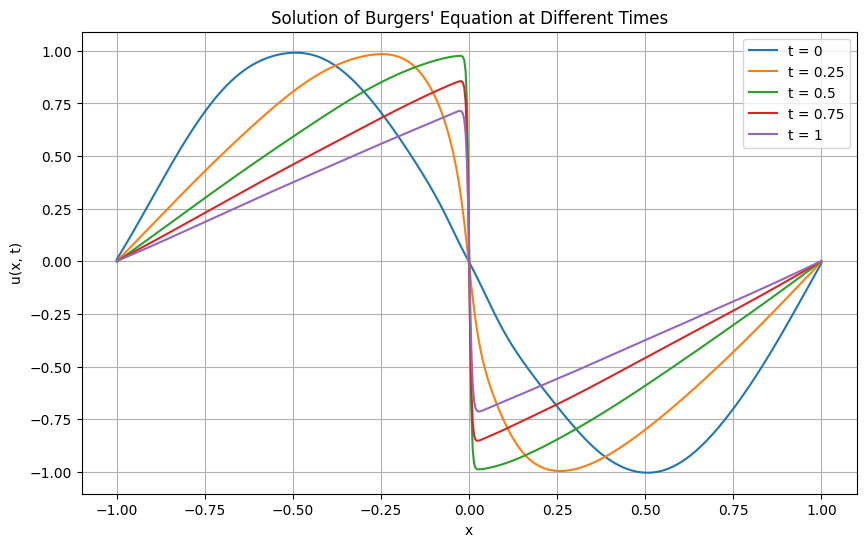

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to plot the results for specific times
def plot_solution_at_times(net, x_values, t_values, device):
    net.eval()  # Put the network in evaluation mode
    plt.figure(figsize=(10, 6))

    for t in t_values:
        # Prepare x and t inputs
        t_fixed = np.full((x_values.shape[0], 1), t)
        pt_x = torch.from_numpy(x_values).float().to(device)
        pt_t = torch.from_numpy(t_fixed).float().to(device)

        # Predict u(x, t) using the trained network
        with torch.no_grad():
            u_pred = net(pt_x, pt_t)
            u_pred = u_pred.cpu().numpy()  # Convert back to NumPy

        # Plot u(x, t) for this specific t
        plt.plot(x_values, u_pred, label=f"t = {t}")

    plt.title("Solution of Burgers' Equation at Different Times")
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.legend()
    plt.grid(True)
    plt.savefig('figures/adam+lbfgs1.png', dpi=300, bbox_inches='tight')
    plt.show()

# Define the x-values and t-values for evaluation
x_values = np.linspace(-1, 1, 500).reshape(-1, 1)  # 500 points in x
t_values = [0, 0.25, 0.5, 0.75, 1]  # Specific time points

# Plot the solution
plot_solution_at_times(net, x_values, t_values, device)



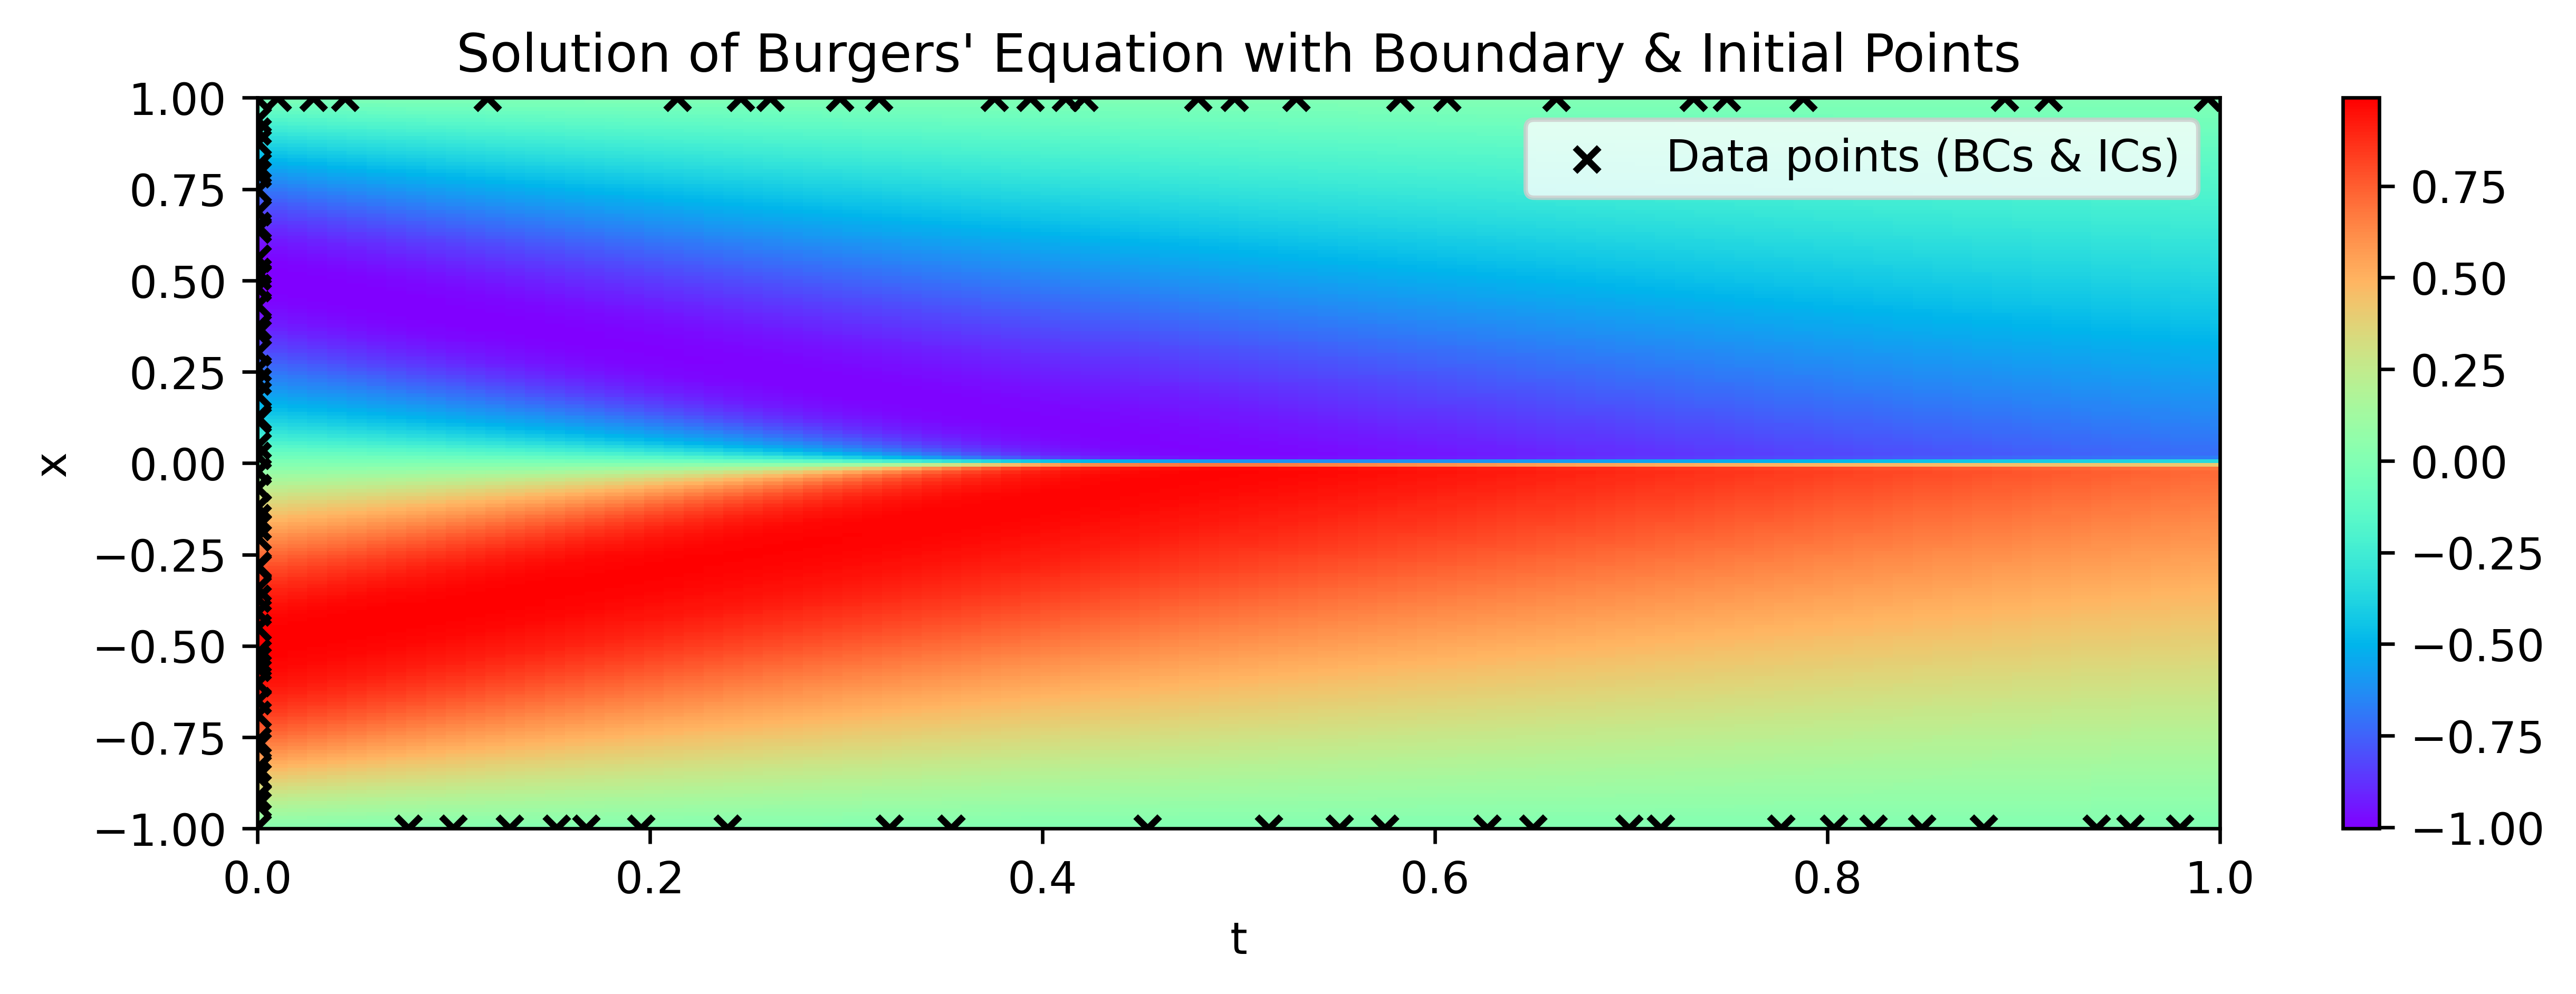

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to plot the solution on a 2D grid and overlay data points
def plot_solution_2d_with_points(net, x_values, t_values, device, t_d, x_d):
    net.eval()  # Put the network in evaluation mode
    
    n = len(t_values)
    m = len(x_values)
    X, T = np.meshgrid(x_values, t_values)  # Create meshgrid for x and t
    
    # Prepare x and t inputs (reshape to ensure proper dimensions)
    pt_x = torch.from_numpy(X.flatten()).float().to(device).unsqueeze(1)  # Flatten X and convert to tensor
    pt_t = torch.from_numpy(T.flatten()).float().to(device).unsqueeze(1)  # Flatten T and convert to tensor
    
    # Predict u(x, t) using the trained network
    with torch.no_grad():
        u_pred = net(pt_x, pt_t)
        u_pred = u_pred.cpu().numpy().reshape(n, m)  # Reshape to the meshgrid shape

    # Plot the solution as a 2D color mesh
    plt.figure(figsize=(10, 3), dpi=600)  # Set figure size and resolution (height further reduced)
    plt.pcolormesh(T, X, u_pred, cmap=cm.rainbow)  # Plot the 2D color mesh
    plt.colorbar()  # Add color bar
    plt.title("Solution of Burgers' Equation with Boundary & Initial Points")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.xlim([0, 1])
    plt.ylim([-1, 1])
    
    # Overlay the boundary and initial condition points (using the existing t_d and x_d)
    plt.scatter(t_d, x_d, marker="x", c="k", s=30, label="Data points (BCs & ICs)")  # Use existing t_d, x_d
    
    plt.legend()  # Add legend for data points
    plt.savefig('figures/adam+lbfgs2.png', dpi=300, bbox_inches='tight')
    plt.show()

# Define the x-values and t-values for evaluation
x_values = np.linspace(-1, 1, 200)  # 200 points in x
t_values = np.linspace(0, 1, 100)   # 100 points in t

# The existing t_d and x_d data (do not redefine these; use the original ones)
# plot_solution_2d_with_points 함수에 기존 데이터인 t_d와 x_d를 그대로 전달

# Plot the solution with boundary and initial points using the existing t_d, x_d
plot_solution_2d_with_points(net, x_values, t_values, device, t_d, x_d)
